In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math
from printTable import printTable # helper function

In [3]:
# parse json file to features - phillip
data_file_name = '../data/data_train.json'
nPoints = 21
with open(data_file_name) as json_file:
    data = json.load(json_file)
    
    # matrix to store distance to keypoint 0, each image stored in row
    # column array to store labels

    distance_feature = np.ones((int(data["num_pics"]), nPoints-1))
    label_vector = np.ones((int(data["num_pics"]),1))
    
    # loop through json to constuct feature array
    for i in range(1, int(data["num_pics"])+1): # use num_pics+1 because range ends at integer before stop value
        label = data["pics"][str(i)]["label"] 
        points = np.array(data["pics"][str(i)]["keypoints"] )
        
        # label array
        label_vector[i-1] = label
        # feature matrix
        pointZero = points[0] # reference distance from point 0
        for j in range(1,nPoints): # calculate distances for points 1-20
            distance_feature[i-1][j-1] = math.sqrt(np.sum(np.square(points[j] - pointZero)))
        
#     print(distance_feature)
#     print(label_vector)

## Single Class SVM

In [12]:
# get data
X = distance_feature
b = label_vector

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
num_features = len(X[0])
w_k = np.zeros((num_features+1, 1))

r = 10 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
b_classes = np.zeros((len(b),len(classes)))
b_test_svm = np.zeros(b_classes.shape)
b_test_ls = np.zeros(b_classes.shape)
w_svm = np.zeros((len(w_k),len(classes)))
w_ls = np.zeros((len(w_k),len(classes)))

for c in classes:
    # form binary labels
    b_svm = np.where(b == c, 1, -1)
    b_classes[:,c] = b_svm.reshape(len(b_svm))
    
    # train svm
    num_steps = 5000
    counter = 0
    counter2 = 0
    for i in range(num_steps):
        # loop through training samples
        l_hinge = np.zeros(w_k.shape)
        for s in range(num_samples):
            # indicator function
            counter2 +=1
            if b_svm[s]*X_svm[s]@w_k <= 1:
                counter +=1
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))
#         w_k = w_k - tau*(l_hinge+2*r*w_k)
        w_tilda = np.copy(w_k)
        w_tilda[-1] = 0
        w_k = w_k - tau*(l_hinge+2*r*w_tilda)
        
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    w_k_ls = np.linalg.inv(X_svm.T@X_svm)@X_svm.T@b_svm # least squares
    w_ls[:,c] = w_k_ls.reshape(len(w_k_ls))
#     print("Weights for class {}:".format(c))
#     print(w_k)

# test svm against known training data
header = ["class", "svm error", "least squares error"]
data = []
for c in classes:
    b_hat_svm = X_svm@w_svm[:,c]
    b_hat_ls = X_svm@w_ls[:,c]
    b_test_svm[:,c] = b_hat_svm.reshape(len(b))
    b_test_ls[:,c] = b_hat_ls.reshape(len(b))

    # find percent incorrect
    num_incorrect_ls = np.sum(np.sign(b_test_ls[:,c]) != b_classes[:,c])
    percent_incorrect_ls = num_incorrect_ls/len(b)*100
    num_incorrect_svm = np.sum(np.sign(b_test_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm), "{:0.2f} %".format(percent_incorrect_ls)])

# print table
printTable(header,data)

| class | svm error | least squares error | 
| ----- | --------- | ------------------- | 
|   0   |   0.00 %  |        0.00 %       | 
|   1   |   0.83 %  |        0.00 %       | 
|   2   |   2.50 %  |        1.67 %       | 
|   3   |   0.83 %  |        2.50 %       | 
|   4   |   0.83 %  |        0.83 %       | 
|   5   |   1.67 %  |        1.67 %       | 


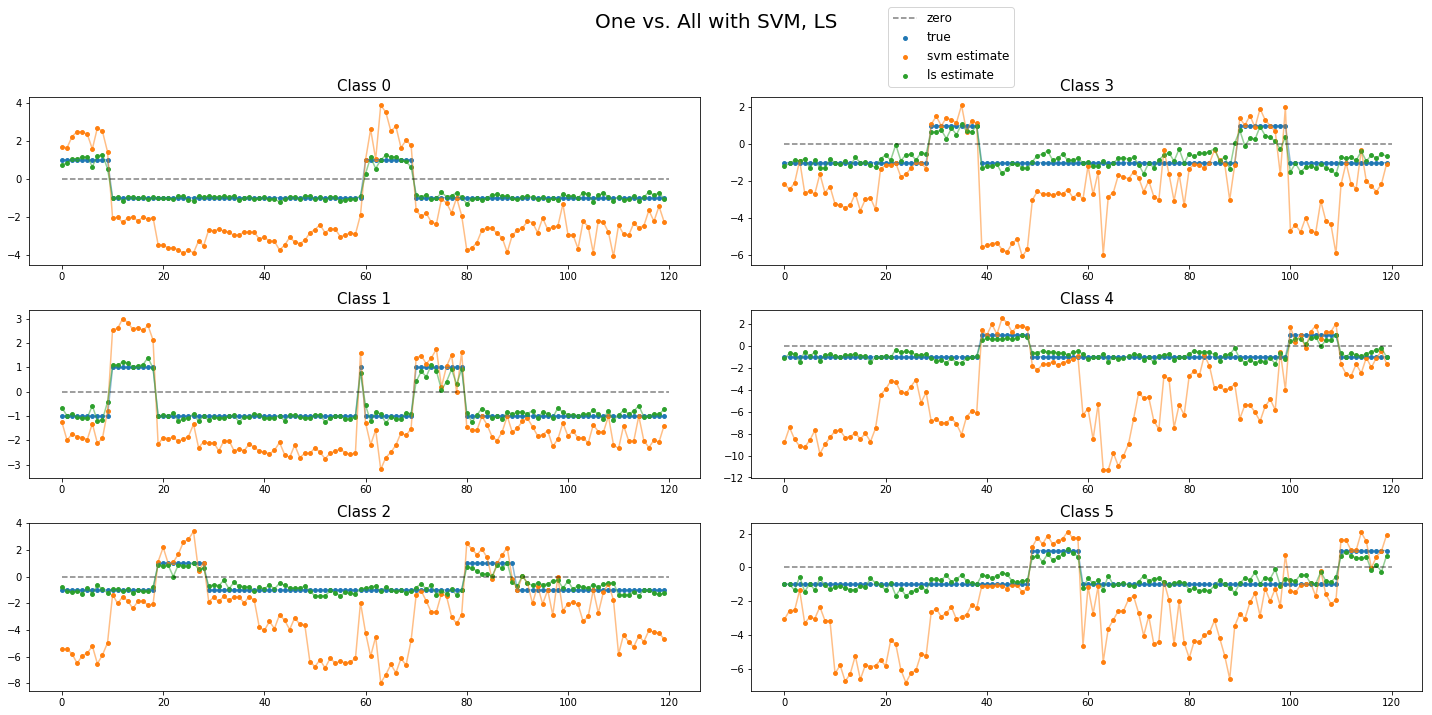

In [13]:
# plot
fig,ax = plt.subplots(3,2)
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]

for c in classes:
    if c < 3:
        count2 = 0
    else:
        count2 = 1
    ax[c%3][count2].set_title("Class {}".format(c),fontsize=15)
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_test_svm[:,c], label="svm estimate", color="C1", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_test_svm[:,c], alpha=0.5, color="C1")
    ax[c%3][count2].scatter(range(len(b_classes[:,c])), b_test_ls[:,c], label="ls estimate", color="C2", s=15)
    ax[c%3][count2].plot(range(len(b_classes[:,c])), b_test_ls[:,c], alpha=0.5, color="C2")
    ax[c%3][count2].plot([0,len(b_classes[:,c])], [0,0], alpha=0.5, linestyle="--", color="k", label="zero")

ax[0][1].legend(bbox_to_anchor=(0.4, 1.3), loc='right', ncol=1,fontsize=12) # legend
title = fig.suptitle("One vs. All with SVM, LS",fontsize=20) # title
fig.tight_layout() # prevent overlapping
plt.show()

In [ ]:
# TODO: implement for predicting new test data

In [10]:
#One vs One maybe

count_svm = np.zeros((6))
count_ls = np.zeros((6))
count_svm_act = np.zeros((6))
count_ls_act = np.zeros((6))
w_class_svd = []
w_class_ls = []


#split into groups of each class
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
for k in range(len(b)):
    if b[k] == 0:
        x0.append(X_svm[k])
    elif b[k] == 1:
        x1.append(X_svm[k])
    elif b[k] == 2:
        x2.append(X_svm[k])
    elif b[k] == 3:
        x3.append(X_svm[k])
    elif b[k] == 4:
        x4.append(X_svm[k])
    elif b[k] == 5:
        x5.append(X_svm[k])
        
#splits data based on classes
Xdat = np.vstack((np.asmatrix(x0),np.asmatrix(x1),np.asmatrix(x2),np.asmatrix(x3),np.asmatrix(x4),np.asmatrix(x5)))
b0 = np.full((len(x0),1),0)
b1 = np.full((len(x1),1),1)
b2 = np.full((len(x2),1),2)
b3 = np.full((len(x3),1),3)
b4 = np.full((len(x4),1),4)
b5 = np.full((len(x5),1),5)
bdat = np.vstack((b0,b1,b2,b3,b4,b5))
num = [0,len(b0),len(b0)+len(b1),len(b0)+len(b1)+len(b2),len(b0)+len(b1)+len(b2)+len(b3),
       len(b0)+len(b1)+len(b2)+len(b3)+len(b4),len(b0)+len(b1)+len(b2)+len(b3)+len(b4)+len(b5)]
print("num: ", num)
    
#calculates the weight for each class
print(Xdat.shape)
for i in range(6):
    for j in range(6):
        if j>i:
            #each class test to create weight
            
            count_svm = np.zeros((6))
            count_ls = np.zeros((6))
            #10 is harcoded length of each group
            #Xtest=np.vstack((Xdat[i*10:(i+1)*10,:],Xdat[j*10:(j+1)*10,:]))
            li = num[i+1] - num[i]
            lj = num[j] - num[j-1]

            Xtest=np.vstack((Xdat[num[i]:num[i] + li,:],Xdat[num[j]:num[j]+lj,:]))
            #btest=np.vstack((i,i,i,i,i,i,i,i,i,i,j,j,j,j,j,j,j,j,j,j))
            #btest=np.vstack((-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1))
            #print(Xtest.shape[1])
            
            bi = np.full((li,1),-1)
            bj = np.full((lj,1),1)
            btest=np.vstack((bi,bj))
            
            
            w_k = np.zeros((Xtest.shape[1],1))
            #print(w_k)
            w_svm = np.zeros((len(w_k),1))
            w_ls = np.zeros((len(w_k),1))
            
            r = 0 # regularizer (aka lambda)
            U, s, V = np.linalg.svd(Xtest)
            tau = 1/s[0]**2 # max stepsize
            print(tau)
            
            # train svm
            num_steps = 1000
            counter = 0
            counter2 = 0
            for m in range(num_steps):
                # loop through training samples
                l_hinge = np.zeros(w_k.shape)
                for s in range(len(Xtest)):
                    # indicator function
                    counter2 +=1
                    
                    if btest[s][0]*Xtest[s,:]@w_k <= 1:
                        counter +=1
                        l_hinge = np.add(l_hinge, -btest[s][0]*Xtest[s].reshape(l_hinge.shape))
                w_k = w_k - tau*(l_hinge+2*r*w_k)

            # save weights
            w_svm = w_k.reshape(len(w_k)) # svm
            w_k_ls = np.linalg.inv(Xtest.T@Xtest)@Xtest.T@btest # least squares
            w_ls = w_k_ls.reshape(len(w_k_ls))
            
            
            #weights for each class

            w_class_svd.append(w_svm)
            w_class_ls.append(w_ls)

            
#determining the b
            
ci1 = 0
ci2 = 1
b_guess_svm = np.zeros((len(X_svm)))
b_guess_ls = np.zeros((len(X_svm)))

for g in range(len(Xdat)):
    for f in range(len(w_class_svd)):
        #determines which of two groups is better
        bst_svm =X_svm[g]@w_class_svd[f].T
        bst_ls =X_svm[g]@w_class_ls[f].T
        
        if bst_svm < 1:
            count_svm_act[ci1] = count_svm_act[ci1] + 1
        elif bst_svm > 1:
            count_svm_act[ci2] = count_svm_act[ci2] + 1
        if bst_ls < 1:
            count_ls_act[ci1] = count_ls_act[ci1] + 1
        elif bst_ls > 1:
            count_ls_act[ci2] = count_ls_act[ci2] + 1
        if ci2<5:
            ci2 = ci2 + 1
        else:
            ci1 = ci1 + 1
            ci2 = ci1 + 1
    print(count_svm_act)
    print(count_ls_act)
    ci1 = 0
    ci2 = 1
    #takes the class with the most count values
    b_guess_svm[g] = np.argmax(count_svm_act)
    b_guess_ls[g] = np.argmax(count_ls_act)
    count_svm_act = np.zeros((6))
    count_ls_act = np.zeros((6))

print(b_guess_svm)
print(b_guess_ls)


num:  [0, 20, 40, 60, 80, 100, 120]
(120, 21)
20
20
2.690737059990657e-08
20
20
2.272516773982065e-08
20
20
2.0967955985913785e-08
20
20
1.7423669195400675e-08
20
20
1.6372029011509787e-08
20
20
2.198600777452128e-08
20
20
2.048477347717977e-08
20
20
1.7124909963581968e-08
20
20
1.6169587619862346e-08
20
20
1.7315682993719965e-08
20
20
1.4902457271030767e-08
20
20
1.4222948450461392e-08
20
20
1.424713445386947e-08
20
20
1.3547775257942908e-08
20
20
1.1627847350541817e-08
[5. 4. 2. 3. 0. 1.]
[5. 4. 3. 1. 1. 1.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 2. 0. 2. 2.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 3. 0. 2. 1.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 3. 1. 1. 1.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 2. 1. 1. 2.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 1. 0. 3. 2.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 2. 0. 2. 2.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 2. 1. 1. 2.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 1. 0. 3. 2.]
[5. 4. 2. 3. 0. 1.]
[5. 4. 2. 1. 2. 1.]
[4. 5. 3. 2. 0. 1.]
[5. 4. 3. 1. 2. 0.]
[4. 5. 3. 2. 0. 1.]
[5. 4. 3. 1. 2. 0.]
[4. 5. 3. 2. 0. 1.]
[4. 5. 2. 2. 2. 0.]
[4. 